In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [83]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # VGG 모델 입력 크기에 맞게 조정
])

In [84]:
# 데이터셋 로드
img_root = 'data'
dataset = ImageFolder(root=img_root, transform=transform)


In [85]:
# 데이터셋 분할 (학습/검증/테스트)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [86]:
# 하이퍼파라미터 설정
batch_size = 32
num_epochs = 30
learning_rate = 0.001

In [87]:
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [88]:
# VGG 모델 로드 및 전이학습 설정
vgg = models.vgg16(pretrained=True)

# VGG 첫 번째 컨볼루션 레이어의 입력 채널 수 수정
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

for param in vgg.features.parameters():
    param.requires_grad = False



c:\Users\Administrator\Downloads\OpenCVTeam\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Downloads\OpenCVTeam\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
num_features = vgg.classifier[0].in_features
vgg.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

In [90]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
# 모델 설정
model = vgg.to(DEVICE)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 리스트 정의
trainList = []
valList = []
testList = []

In [92]:
# 학습 함수
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        trainList.append(loss)
    return running_loss / len(loader)

In [93]:
# 검증 함수
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            valList.append(loss)
    return running_loss / len(loader)

In [94]:
# 학습 루프
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/30, Train Loss: 3.1625, Val Loss: 2.6838
Epoch 2/30, Train Loss: 2.4496, Val Loss: 1.9409
Epoch 3/30, Train Loss: 1.9078, Val Loss: 1.5214
Epoch 4/30, Train Loss: 1.4572, Val Loss: 1.1721
Epoch 5/30, Train Loss: 1.2057, Val Loss: 0.9749
Epoch 6/30, Train Loss: 1.0264, Val Loss: 0.8315
Epoch 7/30, Train Loss: 0.8419, Val Loss: 0.7176
Epoch 8/30, Train Loss: 0.7333, Val Loss: 0.5992
Epoch 9/30, Train Loss: 0.5953, Val Loss: 0.5157
Epoch 10/30, Train Loss: 0.5011, Val Loss: 0.4369
Epoch 11/30, Train Loss: 0.4302, Val Loss: 0.3722
Epoch 12/30, Train Loss: 0.3838, Val Loss: 0.3411


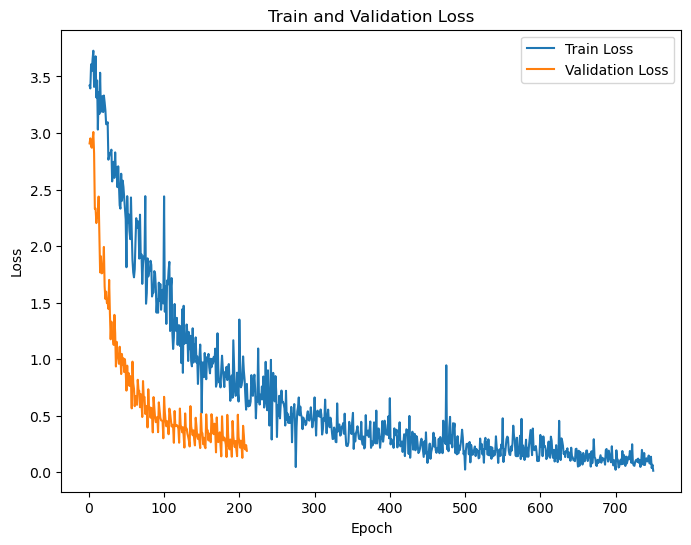

In [ ]:
import matplotlib.pyplot as plt

# 에포크 loss 시각화
plt.figure(figsize=(8, 6))
x = range(1,len(trainList)+1)
plt.plot(x, torch.tensor(trainList).detach().numpy(), label='Train Loss')
x = range(1,len(valList)+1)
plt.plot(x, torch.tensor(valList).detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [ ]:

# 테스트 함수
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    testList.append(accuracy)
    return accuracy


In [ ]:

# 모델 로드 및 테스트
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


/Users/sml/anaconda3/envs/Torch_PY38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Accuracy: 95.50%


/Users/sml/anaconda3/envs/Torch_PY38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


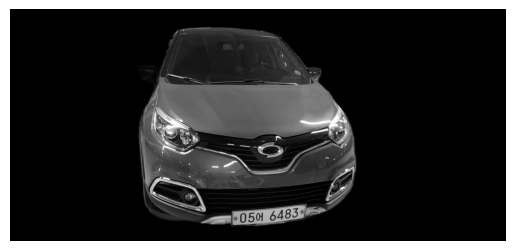

예측 클래스: ev9
예측 확률: 59.00%


In [ ]:
from PIL import Image

# 테스트 결과 출력

img_path = 'test/image2.png'  # 테스트 이미지 경로

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 그레이스케일 변환
    transforms.ToTensor(),
    transforms.Resize((50, 50))
])

img = Image.open(img_path).convert('L')
img_tensor = transform(img).unsqueeze(0)

model.eval()

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

plt.imshow(img, cmap='gray')  # 그레이스케일 이미지로 표시
plt.axis('off')
plt.show()

# 결과 출력
prob = torch.softmax(output, dim=1).detach().squeeze().numpy()
max_prob = max(prob)
rounded_prob = round(max_prob, 2)

class_names = ["ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼"]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
predicted_class = class_names[predicted.item()]

print(f"예측 클래스: {predicted_class}")
print(f"예측 확률: {rounded_prob*100:.2f}%")